# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 
## Homework 3 - Regression Modeling to Forecast Bike Sharing Usage



**Harvard University**<br/>
**Fall 2019**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Chris Tanner

<hr style="height:2pt">

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

/anaconda3/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.24.1) or chardet (2.3.0) doesn't match a supported version!
  RequestsDependencyWarning)


### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.
- Please use .head() when viewing data. Do not submit a notebook that is excessively long because output was not suppressed or otherwise limited. 

<hr style="height:2pt">

![bike_sharing](fig/BSS.png)

<div class="theme">  Main Theme: Multiple Linear Regression, Polynomial Regression, Ridge and Lasso Regression </div>
### Overview 

You are hired by the administrators of the [Capital Bikeshare program](https://www.capitalbikeshare.com) program in Washington D.C., to **help them predict the hourly demand for rental bikes** and **give them suggestions on how to increase their revenue**. Your task is to prepare a short report summarizing your findings and make recommendations.

The predicted hourly demand could be used for planning the number of bikes that need to be available in the system at any given hour of the day. It costs the program money if bike stations are full and bikes cannot be returned, or empty and there are no bikes available. You will use multiple linear regression and polynomial regression and will explore ridge and lasso regression to predict bike usage. The goal is to build a regression model that can predict the total number of bike rentals in a given hour of the day, based on all available information given to you. 

An example of a suggestion to increase revenue might be to offer discounts during certain times of the day either during holidays or non-holidays. Your suggestions will depend on your observations of the seasonality of ridership.

The data for this problem were collected from the Capital Bikeshare program over the course of two years (2011 and 2012).



### Use only the libraries below:

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score

from pandas.plotting import scatter_matrix

### Overview
The initial data set is provided in the file `data/BSS_hour_raw.csv`. You will first add features that will help with the analysis and then separate the data into training and test sets. Each row in this file represents the number of rides by registered users and casual users in a given hour of a specific date. There are 12 attributes in total describing besides the number of users the weather if it is a holiday or not etc: 


- `dteday` (date in the format YYYY-MM-DD, e.g. 2011-01-01)
- `season` (1 = winter, 2 = spring, 3 = summer, 4 = fall)
- `hour` (0 for 12 midnight, 1 for 1:00am, 23 for 11:00pm)
- `weekday` (0 through 6, with 0 denoting Sunday)
- `holiday` (1 = the day is a holiday, 0 = otherwise)
- `weather`
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm
    - 4: Heavy Rain + Thunderstorm + Mist, Snow + Fog 
- `temp` (temperature in Celsius, normalized)
- `atemp` (apparent temperature, or relative outdoor temperature, in Celsius, normalized)
- `hum` (relative humidity, normalized)
- `windspeed` (wind speed, normalized)
- `casual` (number of rides that day made by casual riders, not registered in the system)
- `registered` (number of rides that day made by registered riders)

<div class="exercise"> <b> Question 1 [6pts]: Data Read-In and Processing </b> </div>

In this section, we read in the data and begin one of the most important analytic steps: verifying that the data is what it claims to be.

**1.1** Load the dataset from the csv file `data/BSS_hour_raw.csv` into a pandas dataframe that you name `bikes_df_raw`. Do any of the variables' ranges or averages seem suspect? Do the data types make sense?

**1.2** Notice that the variable in column `dteday` is a pandas `object`, which is **not**  useful when you want to extract the elements of the date such as the year, month, and day. Convert `dteday` into a `datetime` object to prepare it for later analysis.

**Hint:** http://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html

**1.3** Create three new columns in the dataframe:
- `year` with 0 for 2011, 1 for 2012, etc.
- `month` with 1 through 12, with 1 denoting January.
- `counts` with the total number of bike rentals for that **hour** (this is the response variable for later).

### Answers

**1.1 Load the dataset from the csv file...**

In [42]:
path = "./data/BSS_hour_raw.csv"
bikes_df_raw = pd.read_csv(path)

In [43]:
bikes_df_raw.dtypes

dteday         object
season          int64
hour            int64
holiday         int64
weekday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
dtype: object

**1.2 Notice that the variable in column...**

In [44]:
bikes_df_raw['dteday']=pd.to_datetime(bikes_df_raw['dteday'],
                                      format='%Y-%m-%d')

In [45]:
bikes_df_raw.dtypes

dteday        datetime64[ns]
season                 int64
hour                   int64
holiday                int64
weekday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
dtype: object

**1.3 Create three new columns in the dataframe:...**

In [139]:
bikes_df_raw["counts"]=bikes_df_raw["casual"]+bikes_df_raw['registered']
bikes_df_raw["year"]=bikes_df_raw['dteday'].dt.year
bikes_df_raw['month'] = bikes_df_raw['dteday'].dt.month
bikes_df_raw['day'] = bikes_df_raw['dteday'].dt.dayofweek



In [140]:
bikes_df_raw.tail()

,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered,counts,year,month,day
17374,2012-12-31,1,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119,2012,12,0
17375,2012-12-31,1,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89,2012,12,0
17376,2012-12-31,1,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90,2012,12,0
17377,2012-12-31,1,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61,2012,12,0
17378,2012-12-31,1,23,0,1,1,1,0.26,0.2727,0.65,0.1343,12,37,49,2012,12,0


---

<div class='exercise'> <b> Question 2 [20 pts]: Exploratory Data Analysis. </b></div>

In this question we begin hunting for patterns in ridership that shed light on who uses the service and why.

**2.1** Make a new dataframe with the following subset of attributes from the previous dataset and with each entry being just **one** day: 

- `dteday`, the timestamp for that day (fine to set to noon or any other time) 
- `weekday`, the day of the week
- `weather`, the most severe weather that day
- `season`, the season that day falls in
- `temp`, the average temperature
- `atemp`, the average atemp that day
- `windspeed`, the average windspeed that day
- `hum`, the average humidity that day
- `casual`, the **total** number of rentals by casual users
- `registered`, the **total** number of rentals by registered users
- `counts`, the **total** number of rentals of that day

Name this dataframe `bikes_by_day`.

Make a plot showing  the _distribution_ of the number of casual and registered riders on each day of the week.

**Hint:** helpful to use panda's `.groupby()` command

**2.2** Use `bikes_by_day` to visualize how the distribution of **total number of rides** per day (casual and registered riders combined) varies with the **season**. Do you see any **outliers**? Here we use the pyplot's boxplot function definition of an outlier as any value 1.5 times the IQR above the 75th percentile or 1.5 times the IQR below the 25th percentiles. If you see any outliers, identify those dates and investigate if they are a chance occurence, an error in the data collection, or a significant event (an online search of those date(s) might help). 

**2.3** Convert the categorical attributes ('season', 'month', 'weekday', 'weather') into multiple binary attributes using **one-hot encoding** and call this new dataframe `bikes_df`.

**2.4** Split the updated `bikes_df` dataset into a 50-50 train-test split (call them `bikes_train` and `bikes_test`, respectively). Do this in a 'stratified' fashion, ensuring that all months are equally represented in each set.  Use `random_state=90`, a test set size of .5, and stratify on month.  Remember to specify the data's index column as you read it in.

**2.5** Although we asked you to create your train and test set, for consistency and easy checking, we ask that for the rest of this problem set you use the train and test set provided in the files `data/BSS_train.csv` and `data/BSS_test.csv`. Read these two files into dataframes `BSS_train` and `BSS_test`, respectively. Remove the `dteday` column from both the train and the test dataset (its format cannot be used for analysis). 

**2.6** Use pandas' `scatter_matrix` command to visualize the inter-dependencies among the list of predictors listed below in the training dataset. Note and comment on any strongly related variables. [This may take a few minutes to run. You may wish to comment it out until your final submission, or only plot a randomly-selected 10% of the rows]

`cor_columns = ['hour', 'holiday', 'temp', 'atemp', 
               'workingday', 'hum', 'windspeed', 
               'counts', 'casual', 'registered',
               'fall', 'summer', 'spring', 
               'Snow', 'Storm', 'Cloudy']`

**2.7** Make a plot showing the _average_ number of casual and registered riders during each hour of the day. `.groupby` and `.aggregate` should make this task easy. Comment on the trends you observe. 

**2.8** Use the one-hot-encoded `weather` related variables to show how each weather category affects the relationships in question 2.6.  Remember you should have four plots, one for each weather type (Cloudy, Storm, Snow, and Clear), even though there are only three columns related to weather after one-hot-encoding. What do you observe?

### Answers

**2.1 Make a new dataframe...**

In [122]:
bikes_df_raw.columns

Index(['dteday', 'season', 'hour', 'holiday', 'weekday', 'workingday',
       'weather', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered',
       'counts', 'year', 'month', 'day'],
      dtype='object')

- `dteday`, the timestamp for that day (fine to set to noon or any other time) 
- `weekday`, the day of the week
- `weather`, the most severe weather that day
- `season`, the season that day falls in
- `temp`, the average temperature
- `atemp`, the average atemp that day
- `windspeed`, the average windspeed that day
- `hum`, the average humidity that day
- `casual`, the **total** number of rentals by casual users
- `registered`, the **total** number of rentals by registered users
- `counts`, the **total** number of rentals of that day



In [204]:
bikes_by_day=bikes_df_raw.groupby(
    [bikes_df_raw["dteday"].dt.date], as_index=False).agg(
    {
        'dteday':'first',
        'weekday':'first',
        'year':'first',
        'month':'first',
        'holiday':'first',
        'day':'first',
        'weather':max,
        'season':'first',
        'atemp':'mean',
        'windspeed':'mean',
        'hum':'mean',
        'casual':sum,
        'registered':sum,
        'counts':sum    
    }
)

bikes_by_day['temp']=bikes_by_day.atemp.mean() #overall repeating average

In [205]:
bikes_by_day.head(8)

,dteday,weekday,year,month,holiday,day,weather,season,atemp,windspeed,hum,casual,registered,counts,temp
0,2011-01-01,6,2011,1,0,5,3,1,0.363625,0.160446,0.805833,331,654,985,0.474354
1,2011-01-02,0,2011,1,0,6,3,1,0.353739,0.248539,0.696087,131,670,801,0.474354
2,2011-01-03,1,2011,1,0,0,1,1,0.189405,0.248309,0.437273,120,1229,1349,0.474354
3,2011-01-04,2,2011,1,0,1,2,1,0.212122,0.160296,0.590435,108,1454,1562,0.474354
4,2011-01-05,3,2011,1,0,2,1,1,0.229270,0.186900,0.436957,82,1518,1600,0.474354
5,2011-01-06,4,2011,1,0,3,2,1,0.233209,0.089565,0.518261,88,1518,1606,0.474354
6,2011-01-07,5,2011,1,0,4,3,1,0.208839,0.168726,0.498696,148,1362,1510,0.474354
7,2011-01-08,6,2011,1,0,5,3,1,0.162254,0.266804,0.535833,68,891,959,0.474354


Make a plot showing  the _distribution_ of the number of casual and registered riders on each day of the week.



In [206]:
bike_dayofweek=bikes_by_day.groupby(
    [bikes_df_raw["day"]], as_index=False).agg(
    {
        'day':'first',
        'casual':sum,
        'registered':sum,
        'counts':sum      
    }
)

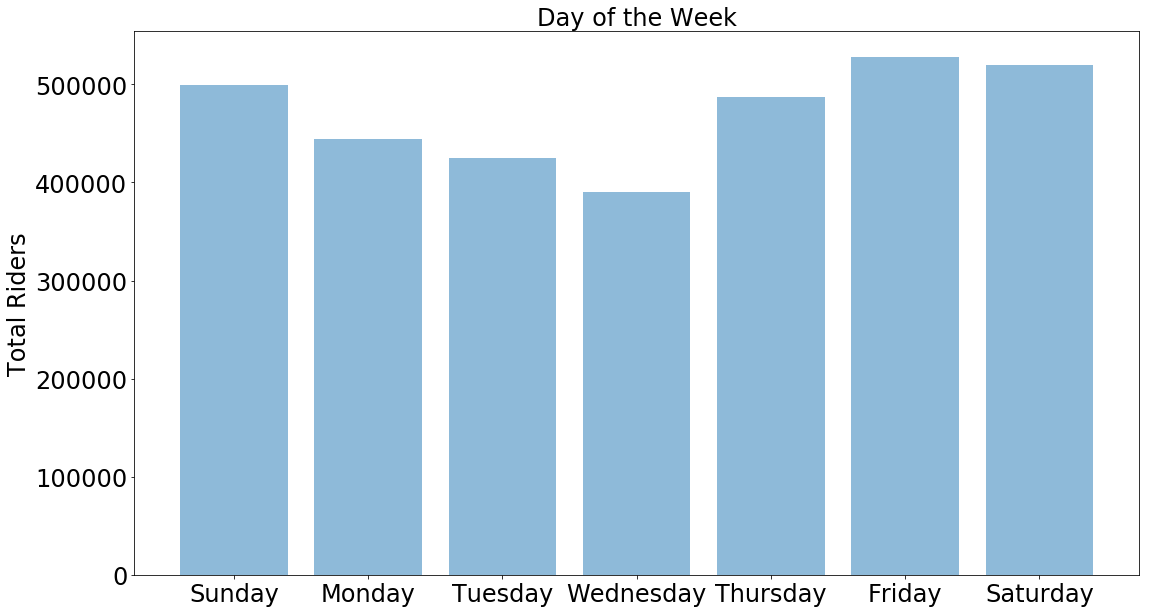

In [207]:
dayoftheweek = ['Sunday','Monday','Tuesday','Wednesday',
               'Thursday','Friday','Saturday']

f, ax = plt.subplots(figsize=(18,10)) # set the size that you'd like (width, height)

plt.bar(bike_dayofweek.index, bike_dayofweek['counts'], align='center', alpha=0.5)
plt.ylabel('Total Riders', fontsize = 24)
plt.xticks(np.arange(7), dayoftheweek)
plt.title('Day of the Week', fontsize = 24)
ax.tick_params(axis = 'both', which = 'major', labelsize = 24)

plt.show()

**2.2 Use `bikes_by_day` to visualize how the distribution...**

Visualize how the distribution of total number of rides per day (casual and registered riders combined) varies with the season. Do you see any outliers? Here we use the pyplot's boxplot function definition of an outlier as any value 1.5 times the IQR above the 75th percentile or 1.5 times the IQR below the 25th percentiles. 

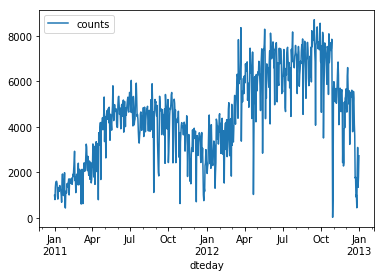

In [208]:
bikes_by_day.plot('dteday',"counts")

In [209]:
bikes_by_day['counts'].describe()

count     731.000000
mean     4504.348837
std      1937.211452
min        22.000000
25%      3152.000000
50%      4548.000000
75%      5956.000000
max      8714.000000
Name: counts, dtype: float64

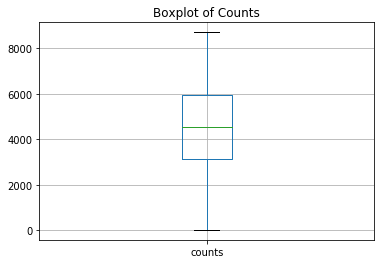

In [210]:
bikes_by_day.boxplot("counts")

plt.title("Boxplot of Counts")
plt.show()

In [211]:
bikes_by_day['low_outlier'] = np.where(
    (
    (bikes_by_day['counts']<(np.percentile(bikes_by_day['counts'],25))/1.5)
    )
    ,1,0    
)

bikes_by_day['high_outlier'] = np.where(
    (
    (bikes_by_day['counts']>np.percentile(bikes_by_day['counts'],75)*1.5)
    )
    ,1,0    
)

In [212]:
print("2011 Low Outliers: ", len(bikes_by_day[(bikes_by_day['low_outlier']==1)
             & 
             (bikes_by_day['year']==2011)]))

print("2011 High Outliers: ", len(bikes_by_day[(bikes_by_day['high_outlier']==1)
             & 
             (bikes_by_day['year']==2012)]))

print("2012 Low Outliers: ", len(bikes_by_day[(bikes_by_day['low_outlier']==1)
             & 
             (bikes_by_day['year']==2012)]))

print("2012 High Outliers: ", len(bikes_by_day[(bikes_by_day['high_outlier']==1)
             & 
             (bikes_by_day['year']==2012)]))

2011 Low Outliers:  89
2011 High Outliers:  0
2012 Low Outliers:  15
2012 High Outliers:  0


In [213]:
bikes_by_day.head()

,dteday,weekday,year,month,holiday,day,weather,season,atemp,windspeed,hum,casual,registered,counts,temp,low_outlier,high_outlier
0,2011-01-01,6,2011,1,0,5,3,1,0.363625,0.160446,0.805833,331,654,985,0.474354,1,0
1,2011-01-02,0,2011,1,0,6,3,1,0.353739,0.248539,0.696087,131,670,801,0.474354,1,0
2,2011-01-03,1,2011,1,0,0,1,1,0.189405,0.248309,0.437273,120,1229,1349,0.474354,1,0
3,2011-01-04,2,2011,1,0,1,2,1,0.212122,0.160296,0.590435,108,1454,1562,0.474354,1,0
4,2011-01-05,3,2011,1,0,2,1,1,0.229270,0.186900,0.436957,82,1518,1600,0.474354,1,0


In [215]:
bikes_by_day[(bikes_by_day['low_outlier']==1)
             & 
             (bikes_by_day['year']>2011)].filter(
    items=['dteday','casual','registered','counts'])

,dteday,casual,registered,counts
366,2012-01-02,244,1707,1951
385,2012-01-21,67,1234,1301
386,2012-01-22,196,1781,1977
407,2012-02-12,73,1456,1529
424,2012-02-29,65,1769,1834
477,2012-04-22,120,907,1027
667,2012-10-29,2,20,22
668,2012-10-30,87,1009,1096
721,2012-12-22,205,1544,1749
722,2012-12-23,408,1379,1787


If you see any outliers, identify those dates and investigate if they are a chance occurence, an error in the data collection, or a significant event (an online search of those date(s) might help).

**Answer:**
Most of the outliers are from 2011 because there is a strong upward trend. This is to be expected, so the real probable issue areas are in 2012. Of the 2012 days, they seem low but not unrealistic. In general, many seem to be around holiday periods. Days around Christmas, Halloween, New Years, and Valentines Day seem to be the low periods. 12/26 has a very low number of newly registered users but this makes a bit of intuitive sense because I wouldn't imagine too many people going to Washington D.C. and starting their bike riding service on that specific day. 

One day seems uncharacteristically low, though. This day is 10/29/2012 where there were only 22 people who used the service (2 new, 20 regular users). It seems like there might be some data quality issues on this day. 

**2.3 Convert the categorical attributes** 

('season', 'month', 'weekday', 'weather') into multiple binary attributes using one-hot encoding and call this new dataframe bikes_df.

In [216]:
bikes_df=bikes_by_day

In [217]:
bikes_df=pd.get_dummies(bikes_df, columns=['season', 'month', 
                                  'weekday', 'weather'])

In [219]:
bikes_df.columns

Index(['dteday', 'year', 'holiday', 'day', 'atemp', 'windspeed', 'hum',
       'casual', 'registered', 'counts', 'temp', 'low_outlier', 'high_outlier',
       'season_1', 'season_2', 'season_3', 'season_4', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'weekday_0', 'weekday_1',
       'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
       'weather_1', 'weather_2', 'weather_3', 'weather_4'],
      dtype='object')

**2.4 Split the updated `bikes_df` dataset into a 50-50 train-test split...** 

Split the updated bikes_df dataset into a 50-50 train-test split (call them bikes_train and bikes_test, respectively). Do this in a 'stratified' fashion, ensuring that all months are equally represented in each set. Use random_state=90, a test set size of .5, and stratify on month. Remember to specify the data's index column as you read it in.

In [224]:
bikes_train, bikes_test = train_test_split(
     bikes_df, test_size=0.5, random_state=90)

**2.5 Although we asked you to create your train and test set...**

Although we asked you to create your train and test set, for consistency and easy checking, we ask that for the rest of this problem set you use the train and test set provided in the files data/BSS_train.csv and data/BSS_test.csv. Read these two files into dataframes BSS_train and BSS_test, respectively. Remove the dteday column from both the train and the test dataset (its format cannot be used for analysis).

In [252]:
BSS_train = pd.read_csv("data/BSS_train.csv")
BSS_test = pd.read_csv("data/BSS_test.csv")

BSS_train= BSS_train.drop(["dteday"],axis=1)
BSS_test= BSS_test.drop(["dteday"],axis=1)

**2.6 Use pandas' `scatter_matrix` command to visualize...**

the inter-dependencies among the list of predictors listed below in the training dataset. Note and comment on any strongly related variables. [This may take a few minutes to run. You may wish to comment it out until your final submission, or only plot a randomly-selected 10% of the rows]

`cor_columns = ['hour', 'holiday', 'temp', 'atemp', 
               'workingday', 'hum', 'windspeed', 
               'counts', 'casual', 'registered',
               'fall', 'summer', 'spring', 
               'Snow', 'Storm', 'Cloudy']`



In [254]:
cor_columns = ['hour', 'holiday', 'temp', 'atemp', 
               'workingday', 'hum', 'windspeed', 
               'counts', 'casual', 'registered',
               'fall', 'summer', 'spring', 
               'Snow', 'Storm', 'Cloudy']

In [255]:
BSS_train_cor=BSS_train[cor_columns]

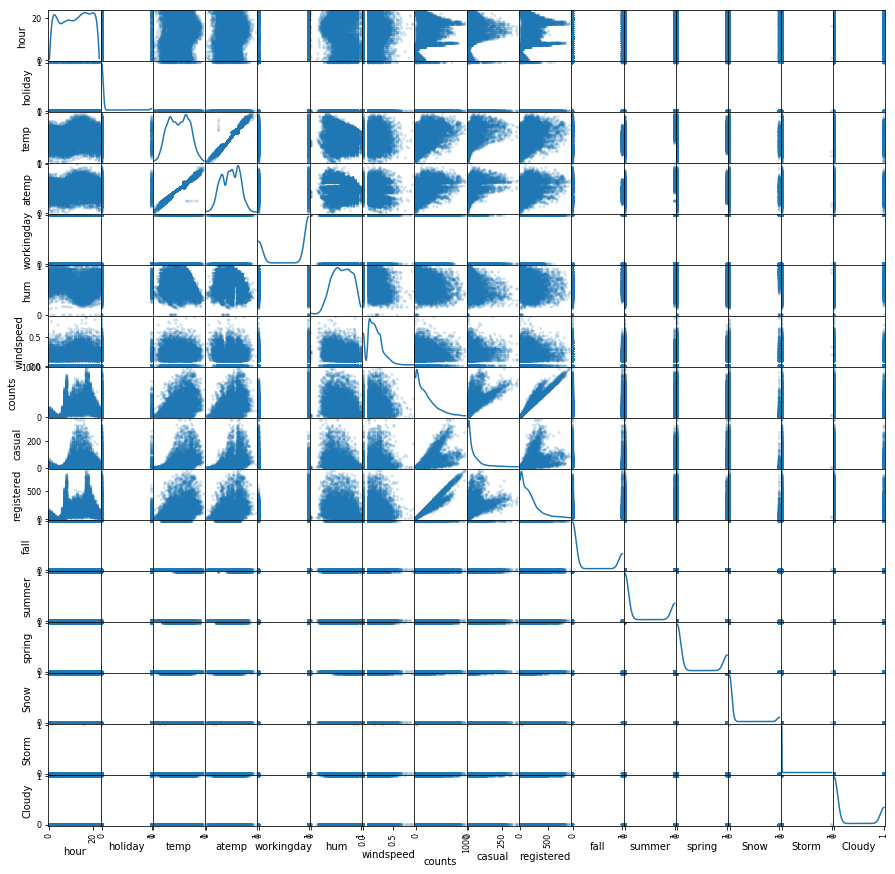

In [271]:
pd.plotting.scatter_matrix(BSS_train_cor, alpha=0.2, 
                           figsize=(15, 15), diagonal='kde')


plt.show()

**2.7 Make a plot showing the _average_ number of casual and registered riders...**

Make a plot showing the average number of casual and registered riders during each hour of the day. .groupby and .aggregate should make this task easy. Comment on the trends you observe.


In [260]:
bikes_df_raw.head()

,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered,counts,year,month,day
0,2011-01-01,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,2011,1,5
1,2011-01-01,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,2011,1,5
2,2011-01-01,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,2011,1,5
3,2011-01-01,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,2011,1,5
4,2011-01-01,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,2011,1,5


In [263]:
bike_hour=bikes_df_raw.groupby(
    [bikes_df_raw["hour"]], as_index=False).agg(
    {
        'casual':sum,
        'registered':sum,
        'counts':sum      
    }
)

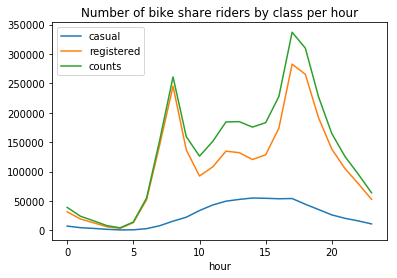

In [269]:
bike_hour.plot("hour")
plt.title("Number of bike share riders by class per hour")
plt.show()

**2.8 Use the weather related variables to show how each weather...** 

2.8 Use the one-hot-encoded weather related variables to show how each weather category affects the relationships in question 2.6. Remember you should have four plots, one for each weather type (Cloudy, Storm, Snow, and Clear), even though there are only three columns related to weather after one-hot-encoding. What do you observe?

In [272]:
bikes_df.head()

,dteday,year,holiday,day,atemp,windspeed,hum,casual,registered,counts,...,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weather_1,weather_2,weather_3,weather_4
0,2011-01-01,2011,0,5,0.363625,0.160446,0.805833,331,654,985,...,0,0,0,0,0,1,0,0,1,0
1,2011-01-02,2011,0,6,0.353739,0.248539,0.696087,131,670,801,...,0,0,0,0,0,0,0,0,1,0
2,2011-01-03,2011,0,0,0.189405,0.248309,0.437273,120,1229,1349,...,1,0,0,0,0,0,1,0,0,0
3,2011-01-04,2011,0,1,0.212122,0.160296,0.590435,108,1454,1562,...,0,1,0,0,0,0,0,1,0,0
4,2011-01-05,2011,0,2,0.229270,0.186900,0.436957,82,1518,1600,...,0,0,1,0,0,0,1,0,0,0


In [318]:
cor_columns = ['temp','atemp', 'windspeed', 'hum',
       'casual', 'registered', 'counts']

Correlation Matrix Where Observations Have weather_1 == 1
151 Observations


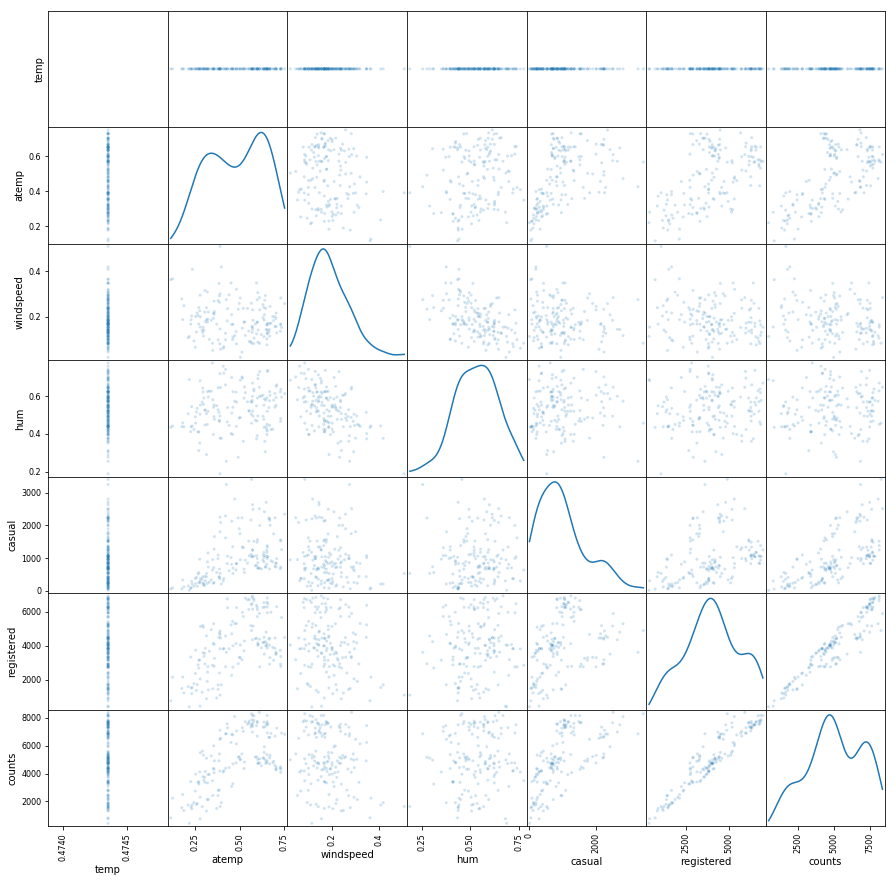

Correlation Matrix Where Observations Have weather_2 == 1
280 Observations


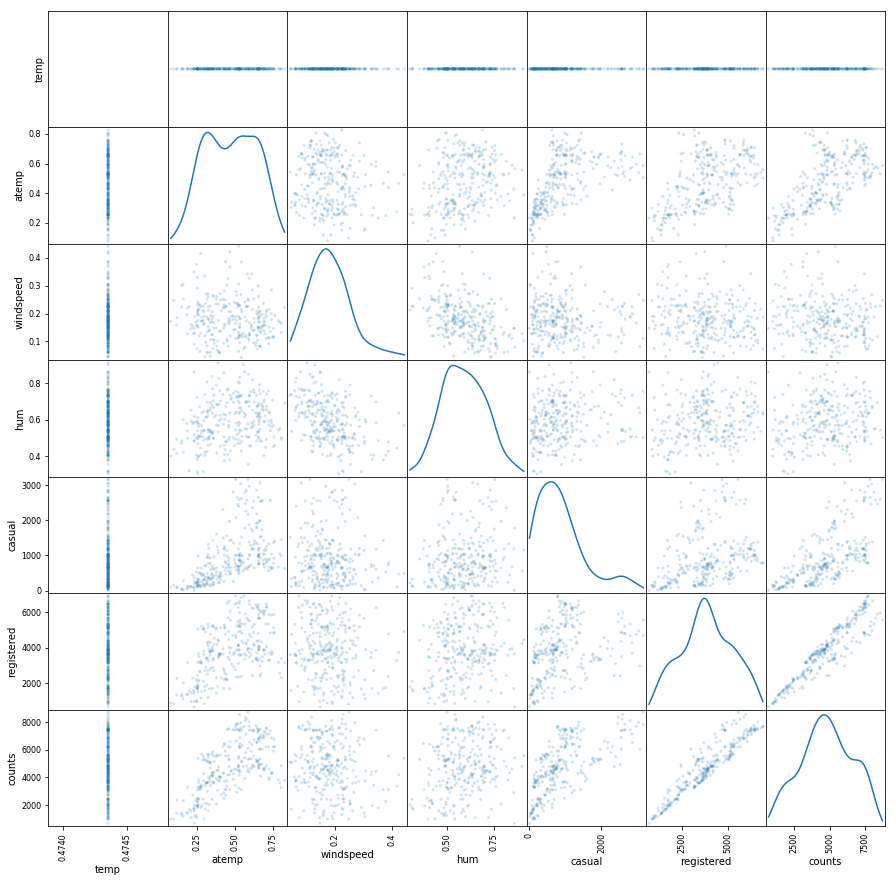

Correlation Matrix Where Observations Have weather_3 == 1
297 Observations


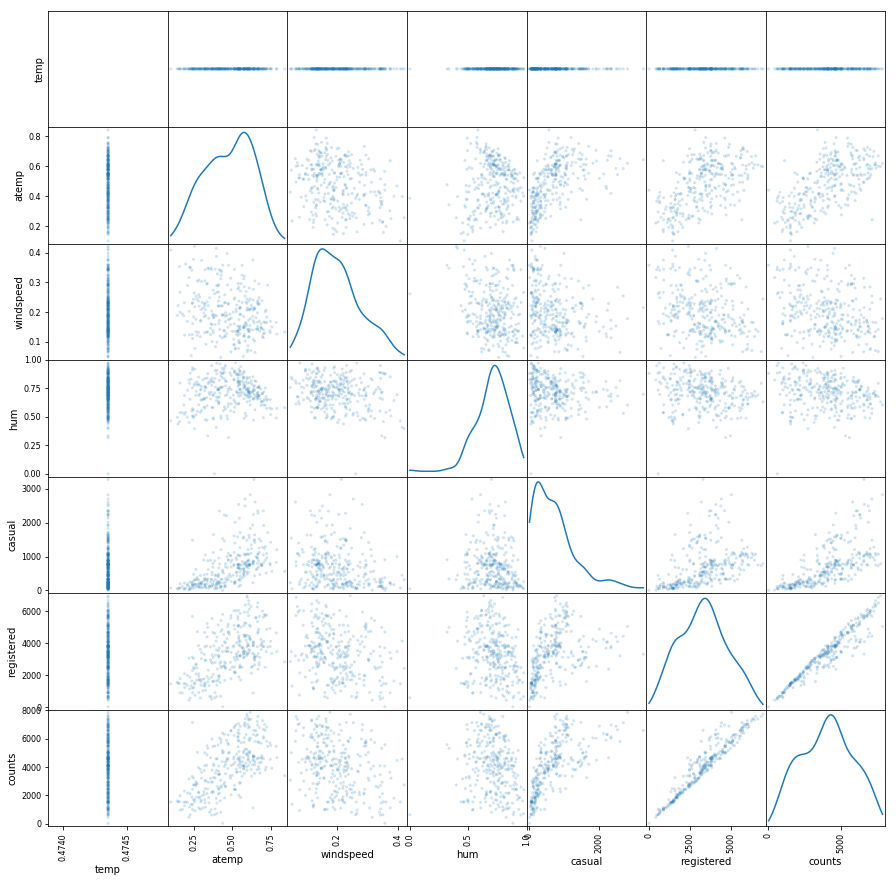

Correlation Matrix Where Observations Have weather_4 == 1
3 Observations


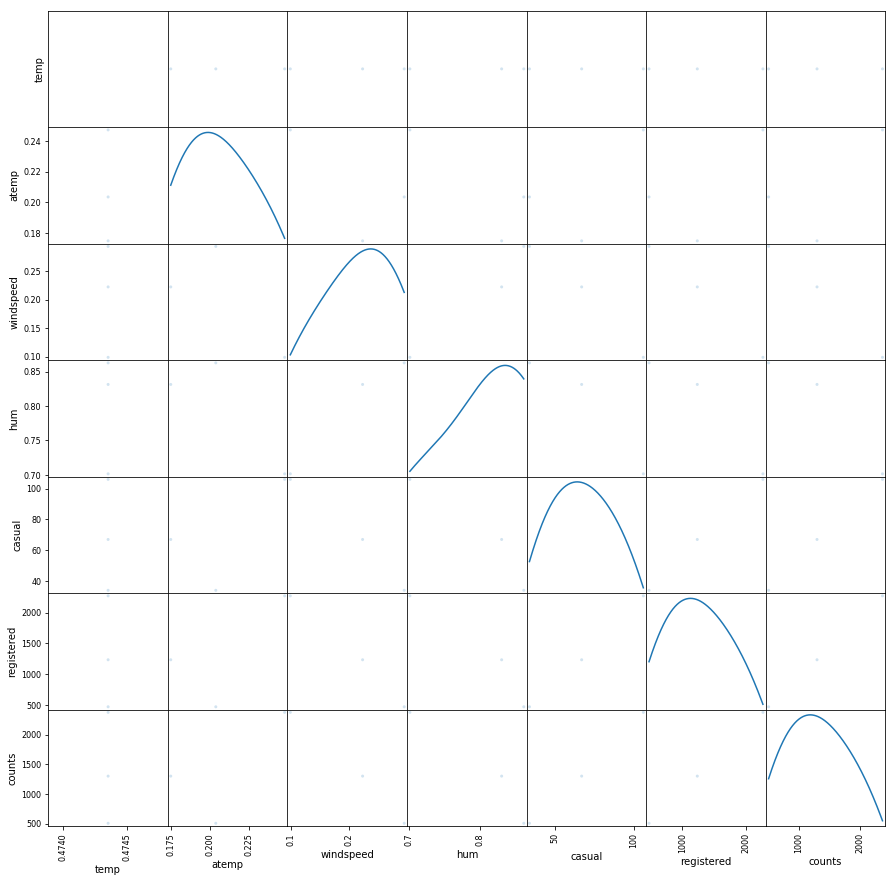

In [321]:
import warnings
warnings.filterwarnings('ignore')

for x in range(1,5):
    y = "weather_"+str(x)
    bike_temp = bikes_df[bikes_df[y]==1]
    bike_temp_cor=bike_temp[cor_columns]
#    ax[x-1].plot(bike_hour["hour"]).np.where(bikes_df['season']==1)
#    ax[x-1].title.set_text('Test Data')
    print("Correlation Matrix Where Observations Have " + y + " == 1")
    print(str(len(bike_temp))+" Observations")
    
    pd.plotting.scatter_matrix(bike_temp_cor, alpha=0.2, 
                           figsize=(15, 15), diagonal='kde')

    
    plt.show()

---

<div class='exercise'> <b> Question 3 [18pts]: Multiple Linear Regression to Predict Hourly Ridership </b> </div>


**3.1** Use statsmodels to fit a multiple linear regression model to the training set using all the useable predictors (nothing that `count` was derived of and no interactions or polynomial terms) to predict `counts`, and report its $R^2$ score on the train and test sets.  Call this set of predictors `X_train`.

**3.2** Examine the estimated coefficients and report which ones are statistically significant at a significance level of 5% (p-value < 0.05). 

**3.3** You should see some strange estimates for the predictors representing months.  Carefully interpret the `July` coefficient, and explain why this result is likely occurring (be as specific as possible). 

**3.4** To diagnose the model, make two plots: first a histogram of the residuals, and second a plot of the residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Draw a horizontal line denoting the zero residual value on the Y-axis. What do the plots reveal about the OLS assumptions (linearity, constant variance, and normality)?

**3.5** Perhaps we can do better via a model with polynomial terms. Build a dataset `X_train_poly` from your `X_train` data from question 3.1 with added $x^2$ terms for `temp`, `hour`, and `humidity`. Are these polynomial terms important? How does predicted ridership change as each of `temp`, `hour`, and `humidity` increase?

**3.6** You should have received a warning regarding the presence of _multicolinearity_ in the model in 3.1.  Create a new dataset `X_train_drop` by dropping the following predictors from `X_train`:  `workingday` `atemp` `spring` `summer` and `fall` and fit a multiple linear regression model to the variables the remain.  Are the estimates more sensible in this model?  And explain in your own words why multicolinearity can lead to erroneous coefficient values.



### Answers

**3.1 Use statsmodels to fit a multiple linear regression model...**

In [ ]:
# your code here

**3.2 Examine the estimated coefficients and report...**

In [ ]:
# your code here

**3.3 You should see some strange estimates for the predictors representing months...** 

*your answer here*


**3.4 To diagnose the model, make two plots:...**

In [ ]:
# your code here

**3.5 Perhaps we can do better via a model...**

In [ ]:
# your code here

**3.6 You should have received a warning regarding the presence of _multicollinearity_...**

In [ ]:
# your code here

---

<div class='exercise'> <b> Question 4 [20pts]: Regression Models with Polynomial and Interaction Terms </b> </div>

**4.1** Drop the variables `workingday`, `atemp`, `spring`, `summer`, `fall`, and  `dteday` from `BSS_train` (if any of them still remain).

**4.2** Write a function to standardize a provided subset of columns in your training/validation/test sets. Remember that while you will be scaling all of your data, you must learn the scaling parameters (mean and SD) from only the training set.

Test your code by building a list of all non-binary columns from `X_train` into a dataset called `practice_X_train` and scaling only those columns. Call the result `practice_X_train_scaled`. Display the `.describe()` and verify that you have correctly scaled all columns, including the polynomial columns.

**Hint: employ the provided list of binary columns and use `pd.columns.difference()`**

`binary_columns = [ 'holiday', 'workingday','Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'spring',
       'summer', 'fall', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm']`


**4.3** Write a code to augment your a dataset with higher-order features for `temp`, `hum`,`windspeed`, and `hour`. You should include ONLY the pure powers of these columns. So with degree=2 you should produce `temp^2` and `hum^2` but not `temp*hum` or any other two-feature interactions. 

Encapsulate this process as a function with appropriate inputs and outputs, and test your code by producing `practice_X_train_poly`, a training dataset with quadratic and cubic features built from `practice_X_train_scaled`, and printing `practice_X_train_poly`'s column names and `.head()`.

**4.4** Write code to add interaction terms to the model. Specifically, we want interactions between the continuous predictors (`temp`, `hum`,`windspeed`) and the month and weekday dummies (`Feb`, `Mar`...`Dec`, `Mon`, `Tue`, ... `Sat`). That means you SHOULD build `temp*Feb` and `hum*Mon` and so on, but NOT `Feb*Mar` and NOT `Feb*Tue`. The interaction terms should always be a continuous feature times a month dummy or a continuous feature times a weekday dummy.

Encapsulate this process as a function with appropriate inputs and outputs, and test your code by adding interaction terms to `practice_X_train_poly` and show its column names and `.head()`**

**4.5** Combine all your code so far into a function named `get_design_mats` that takes in `BSS_train`, `BSS_test`, the names of columns for polynomial, the target column, the columns to be dropped and produces computation-ready design matrices `X_train` and `X_test` and responses `y_train` and `y_test`. Your final function should build correct, scaled design matrices with the stated interaction terms and any polynomial degree.


**4.6** For each degree in 1 through 8:

1.  Build the training design matrix and validation design matrix using the function `get_design_mats` with polynomial terms up through the specified degree.

2.  Fit a regression model to the training data.

3.  Report the model's score on the test data.

**4.7** Discuss patterns you see in the results from 4.5. Which model would you select, and why?

### Answers

**4.1 Drop...**

In [ ]:
# your code here

**4.2 Write a function to standardize...**

In [ ]:
# your code here

**4.3 Write code to augment your a dataset with higher-order features for...**

In [ ]:
# your code here

**4.4 Write code to add interaction terms to the model...**

In [ ]:
# your code here

**4.5 Combine all your code so far into a function named...**

In [ ]:
def get_design_mats(train_df, val_df,  degree, 
                    columns_forpoly=['temp', 'hum','windspeed', 'hour'],
                    target_col='counts', 
                    bad_columns=['counts']):
    """
    :param train_df: The training data
    :param val_df: Your test/validation data
    :param columns_forpoly: List containing the column name for which we want to create 
                            polynomial terms
    :param target_col: The response variable column
    :param bad_columns: The columns you want to drop
    """
    
    # add code here 
    return x_train,y_train, x_val,y_val

**4.6 For each degree in 1 through 8...**

In [ ]:
# your code here

**4.7 Discuss patterns you see in the results...**

*your answer here*

---

<div class='exercise'> <b> Question 5 [20pts]: Regularized Models </b> </div>

**5.1** Let's try regularizing our models via ridge regression. Split the training set, `BSS_train`, into an 80-20 train-validation split.  Build a table showing the validation set $R^2$ of polynomial models with degree from 1-8, regularized at the levels $\lambda = (.01, .05, .1,.5, 1, 5, 10, 50, 100)$. Do not perform cross validation at this point, simply report performance on the single validation set. 

**5.2** Find the best-scoring degree and regularization combination.

**5.3** It's time to see how well our selected model will do on future data. Use the earlier created test dataset, do any required formatting, and report the best model's $R^2$ score. How does it compare to the validation set score that made us choose this model? Does the test set simply have observations that are more difficult or easier to predict?

**5.4** Build a dataset with polynomial degree 1 and fit an OLS model, a Ridge model, and a Lasso model. Use `RidgeCV` and `LassoCV` to select the best regularization level from among `(.1,.5,1,5,10,50,100)`. 

Note: On the lasso model, you may need to increase `max_iter` (start with 100,000) for the optimization to converge.

**5.5** Plot histograms of the coefficients found by each of OLS, ridge, and lasso. What trends do you see in the magnitude of the coefficients?

**5.6** The plots above show the overall distribution of coefficient values in each model, but do not show how each model treats individual coefficients. Build a plot which cleanly presents, for each feature in the data, 1) The coefficient assigned by OLS, 2) the coefficient assigned by ridge, and 3) the coefficient assigned by lasso.

**Hint: Bar plots are a possible choice, but you are not required to use them**

**Hint: use `xticks` to label coefficients with their feature names**

**5.7** What trends do you see in the plot above? How do the three approaches handle the correlated pair `temp` and `atemp`?

### Answers

**5.1 Let's try regularizing our models via...** 

In [ ]:
# your code here

**5.2 Find the best-scoring degree and regularization combination.**

In [ ]:
# your code here

**5.3 It's time to see how well our selected model...**


In [ ]:
# your code here

**5.4 Build a dataset with polynomial degree 1...**

In [ ]:
# your code here

**5.5 Plot histograms of the coefficients found...**

In [ ]:
# your code here

**5.6 The plots above show the overall distribution of... **

In [ ]:
# your code here

**5.7 What trends do you see...**

In [ ]:
# your code here

*your answer here*

---

<div class='exercise'> <b> Question 6 [16 pts]: Reflection </b></div>
These problems are open-ended, and you are not expected to write more than 2-3 sentences. We are interested in seeing that you have thought about these issues; you will be graded on how well you justify your conclusions here, not on what you conclude.

**6.1** Reflect back on the `get_design_mats` function you built. In what way was writing this function useful in your analysis? What issues might you have encountered if you copy/pasted the model-building code instead of tying it together in a function? Does a `get_design_mat` function seem wise in general, or are there better options?

**6.2** What are the costs and benefits of applying ridge/lasso regularization to an overfit OLS model, versus setting a specific degree of polynomial or forward selecting polynomial features for the model?

**6.3** This pset posed a purely predictive goal: forecast ridership as accurately as possible. How important is interpretability in this context? Considering, e.g., your lasso and ridge models from Question 5, how would you react if the models predicted well, but the coefficient values didn't make sense once interpreted?

**6.4** Reflect back on our original goal of helping BikeShare predict what demand will be like in the week ahead, and thus how many bikes they can bring in for maintenance. In your view, did we accomplish this goal? If yes, which model would you put into production and why? If not, which model came closest, what other analyses might you conduct, and how likely do you think they are to work?


### Answers

**6.1 Reflect back on the get_design_mats function you built...**

*your answer here*

**6.2 What are the costs and benefits of applying ridge/lasso...**

*your answer here*

**6.3 This pset posed a purely predictive goal: forecast ridership...**

*your answer here*

**6.4 Reflect back on our original goal of helping BikeShare predict...**

*your answer here*